# Milestone 2

## 0: Loading Data

In [51]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [52]:

conn = sqlite3.connect('FORM13F.db')
cursor = conn.cursor()
table_name = "INFOTABLE_2024_Q3"
s = f"""SELECT * FROM {table_name};"""
df_infotable = pd.read_sql(s, conn)
df_summarypage = pd.read_sql(f"SELECT * FROM SUMMARYPAGE_2024_Q3;", conn)
df_coverpage = pd.read_sql(f"SELECT * FROM COVERPAGE_2024_Q3;", conn)
conn.close()

Our project involves data from the US Securities and Exchange Commission (SEC) Form 13F. From `sec.gov`:

*Form 13F was adopted pursuant to statutory directive designed to provide the Commission with data from larger managers about their investment activities and holdings. The FORM 13F data sets are extracted from EDGAR FORM 13F XML ﬁlings in a ﬂat ﬁle format to assist users in constructing the data for analysis.*

*Note that the data includes FORM 13F EDGAR information "as filed" in EDGAR document submissions including amendments of prior submissions. Data in this submitted form may contain redundancies, inconsistencies, and discrepancies relative to prior submissions and other publication formats*

For our project, we will analyze two tables, `INFOTABLE` and `SUMMARYPAGE`. 

`INFOTABLE` has the following columns:

In [53]:
print("Columns in `INFOTABLE")
for col in df_infotable.columns:
    print(col)

Columns in `INFOTABLE
ACCESSION_NUMBER
INFOTABLE_SK
NAMEOFISSUER
TITLEOFCLASS
CUSIP
FIGI
VALUE
SSHPRNAMT
SSHPRNAMTTYPE
PUTCALL
INVESTMENTDISCRETION
OTHERMANAGER
VOTING_AUTH_SOLE
VOTING_AUTH_SHARED
VOTING_AUTH_NONE


`SUMMARYPAGE` has the following columns:

In [54]:
for col in df_summarypage.columns:
    print(col)

ACCESSION_NUMBER
OTHERINCLUDEDMANAGERSCOUNT
TABLEENTRYTOTAL
TABLEVALUETOTAL
ISCONFIDENTIALOMITTED


Below is a more detailed description of each column:

### `INFOTABLE`

- `ACCESSION_NUMBER`: Unique identifier assigned by the SEC to each EDGAR submission.
- `INFOTABLE_SK`: Infotable surrogate key.
- `NAMEOFISSUER`: Name of issuer.
- `TITLEOFCLASS`: Title of class.
- `CUSIP`: CUSIP number of security.
- `FIGI`: Financial Instrument Global Identiﬁer (FIGI)
- `VALUE`: Market value. Starting on January 3, 2023, market value is reported rounded to the nearest dollar. Previously, market value was reported in thousands.
- `SSHPRNAMT`: Number of shares or principal amount.
- `SSHPRNAMTTYPE`: Shares (SH) or principal amount (PRN) type.
- `PUTCALL`: Put/call
- `INVESTMENTDISCRETION`: Investment discretion.
- `OTHERMANAGER`: Sequence number of other manager included in report with whom discretion is shared.
- `VOTING_AUTH_SOLE`: Voting authority sole.
- `VOTING_AUTH_SHARED`: Voting authority shared.
- `VOTING_AUTH_NONE`: Voting authority none.

### `SUMMARYPAGE`
- `ACCESSION_NUMBER`: Unique identiﬁer assigned by the SEC to each EDGAR submission. 
- `OTHERINCLUDEDMANAGERSCOUNT`: Number of other included managers.
- `TABLEENTRYTOTAL`: Table entry total.
- `TABLEVALUETOTAL`: Table value total.
- `ISCONFIDENTIALOMITTED`: Is confidential omitted.

### `COVERPAGE`
- `ACCESSION_NUMBER`: Unique identiﬁer assigned by the SEC to each EDGAR submission.
- `REPORTCALENDARORQUARTER`: Report for the calendar year of quarter ended in (DD-MON-YYYY) format.
- `ISAMENDMENT`: Check here if amendment.
- `AMENDMENTNO`: Amendment number.
- `AMENDMENTTYPE`: Amendment type.
- `CONFDENIEDEXPIRED`: Whether confidential treatment request is denied or expired.
- `DATEDENIEDEXPIRED`: Pursuant to a request for conﬁdential treatment expired or denied in (DD-MON-YYYY) format.
- `DATEREPORTED`: Date securities holdings reported pursuant to a request for confidential treatment in (DD-MON-YYYY) format.




## 1: Missing Values

In [55]:
print(f"Coverpage has {len(df_coverpage)} rows.")
print(f"Infotable has {len(df_infotable)} rows.")
print(f"Summary page has {len(df_summarypage)} rows.")

Coverpage has 10117 rows.
Infotable has 3278515 rows.
Summary page has 8244 rows.


### Infotable

In [56]:
print("Number of missing values in each column of the infotable:")
print(df_infotable.isna().sum())

Number of missing values in each column of the infotable:
ACCESSION_NUMBER              0
INFOTABLE_SK                  0
NAMEOFISSUER                799
TITLEOFCLASS               1010
CUSIP                         0
FIGI                    3018205
VALUE                         0
SSHPRNAMT                     0
SSHPRNAMTTYPE                 0
PUTCALL                 3162718
INVESTMENTDISCRETION          0
OTHERMANAGER            1758980
VOTING_AUTH_SOLE              0
VOTING_AUTH_SHARED            0
VOTING_AUTH_NONE              0
dtype: int64


The columns `NAMEOFISSUER`, `TITLEOFCLASS`, `FIGI`, `PUTCALL`, and `OTHERMANAGER` have missing values. However, this will not be an issue. Note that `NAMEOFISSUER`, `TITLEOFCLASS`, and `FIGI` can be used to identifier the specific security, but this is unnecessary because the securities can be uniquely identified using the `CUSIP`. 

The `PUTCALL` column has many missing values, but these are easily filled in. If the value is missing, we can assume that the security is neither a put nor a call, but instead owned outright.

`OTHERMANAGER` has missing values, but this is not an issue. This column is only used when the investment discretion is shared with another manager. If the value is missing, then the investment discretion is not shared. 

In [57]:
df_infotable['PUTCALL'] = df_infotable['PUTCALL'].fillna('N/A')
df_infotable['OTHERMANAGER'] = df_infotable['OTHERMANAGER'].fillna('N/A')

### Summary Page

In [58]:
print("Number of missing values in each column of the summary page:")
print(df_summarypage.isna().sum())

Number of missing values in each column of the summary page:
ACCESSION_NUMBER                 0
OTHERINCLUDEDMANAGERSCOUNT       0
TABLEENTRYTOTAL                  0
TABLEVALUETOTAL                  0
ISCONFIDENTIALOMITTED         2743
dtype: int64


The only column with missing values is `ISCONFIDENTIALOMITTED`. This column is a boolean column that indicates whether the data is confidential. If the value is missing, we can assume that the data is not confidential.

In [59]:
df_summarypage['ISCONFIDENTIALOMITTED'] = df_summarypage['ISCONFIDENTIALOMITTED'].fillna('N/A')

## Data Imbalance
Below are visualizations of the data imbalances for various columns.

### `COVERPAGE`

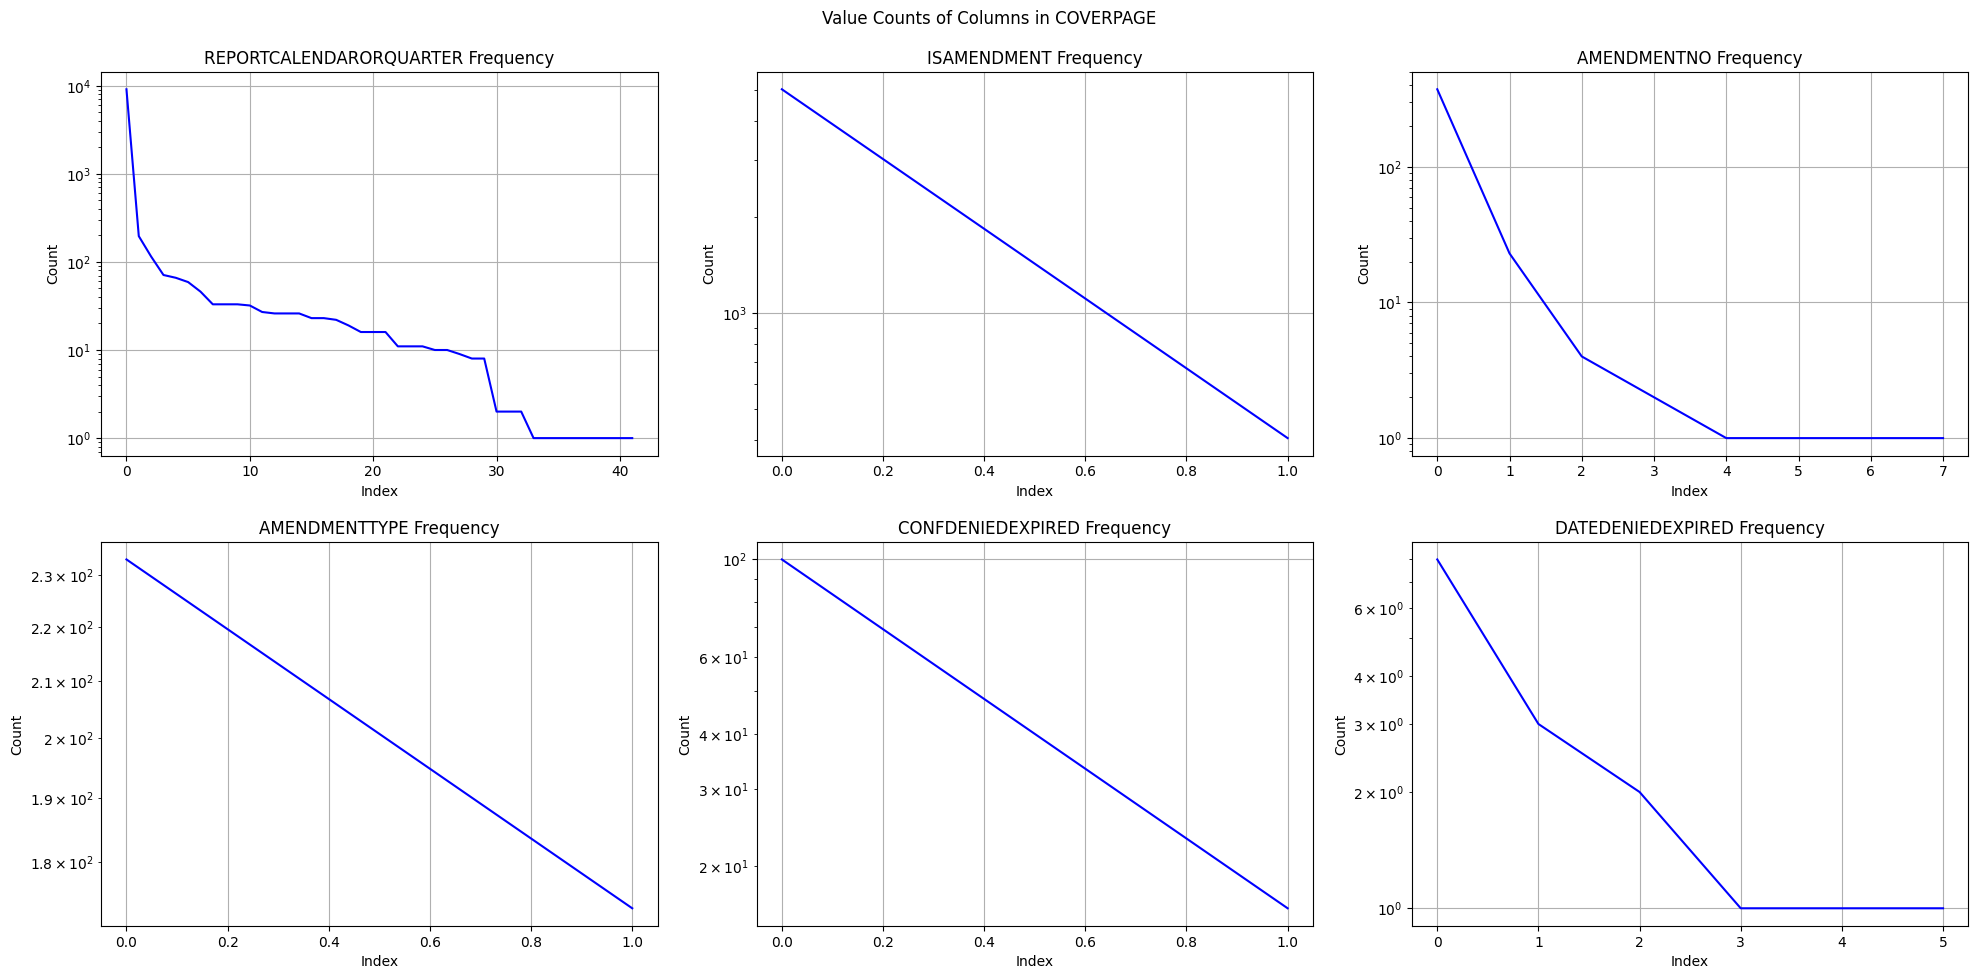

In [60]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

ax[0,0].plot(df_coverpage['REPORTCALENDARORQUARTER'].value_counts().values, color='blue')
# sns.countplot(data=df_coverpage, x='REPORTCALENDARORQUARTER', ax=ax[0,0])
ax[0,0].set_yscale('log')
ax[0,0].set_title("REPORTCALENDARORQUARTER Frequency")
ax[0,0].set_xlabel("Index")
ax[0,0].set_ylabel("Count")
ax[0,0].grid(True)

ax[0,1].plot(df_coverpage['ISAMENDMENT'].value_counts().values, color='blue')
ax[0,1].set_yscale('log')
ax[0,1].set_title("ISAMENDMENT Frequency")
ax[0,1].set_xlabel("Index")
ax[0,1].set_ylabel("Count")
ax[0,1].grid(True)

ax[0,2].plot(df_coverpage['AMENDMENTNO'].value_counts().values, color='blue')
ax[0,2].set_yscale('log')
ax[0,2].set_title("AMENDMENTNO Frequency")
ax[0,2].set_xlabel("Index")
ax[0,2].grid(True)
ax[0,2].set_ylabel("Count")

ax[1,0].plot(df_coverpage['AMENDMENTTYPE'].value_counts().values, color='blue')
ax[1,0].set_yscale('log')
ax[1,0].set_title("AMENDMENTTYPE Frequency")
ax[1,0].set_xlabel("Index")
ax[1,0].set_ylabel("Count")
ax[1,0].grid(True)

ax[1,1].plot(df_coverpage['CONFDENIEDEXPIRED'].value_counts().values, color='blue')
ax[1,1].set_yscale('log')
ax[1,1].set_title("CONFDENIEDEXPIRED Frequency")
ax[1,1].set_xlabel("Index")
ax[1,1].set_ylabel("Count")
ax[1,1].grid(True)

ax[1,2].plot(df_coverpage['DATEDENIEDEXPIRED'].value_counts().values, color='blue')
ax[1,2].set_yscale('log')
ax[1,2].set_title("DATEDENIEDEXPIRED Frequency")
ax[1,2].set_xlabel("Index")
ax[1,2].set_ylabel("Count")
ax[1,2].grid(True)

# ax[2,0].plot(df_infotable['DATEREPORTED'].value_counts().values, color='blue')
# ax[2,0].set_yscale('log')
# ax[2,0].set_title("VOTING_AUTH_SOLE Frequency")
# ax[2,0].set_xlabel("Index")
# ax[2,0].set_ylabel("Count")
# ax[2,0].grid(True)

plt.suptitle("Value Counts of Columns in COVERPAGE")
plt.tight_layout(pad=1.5)
plt.show()


### `INFOTABLE`

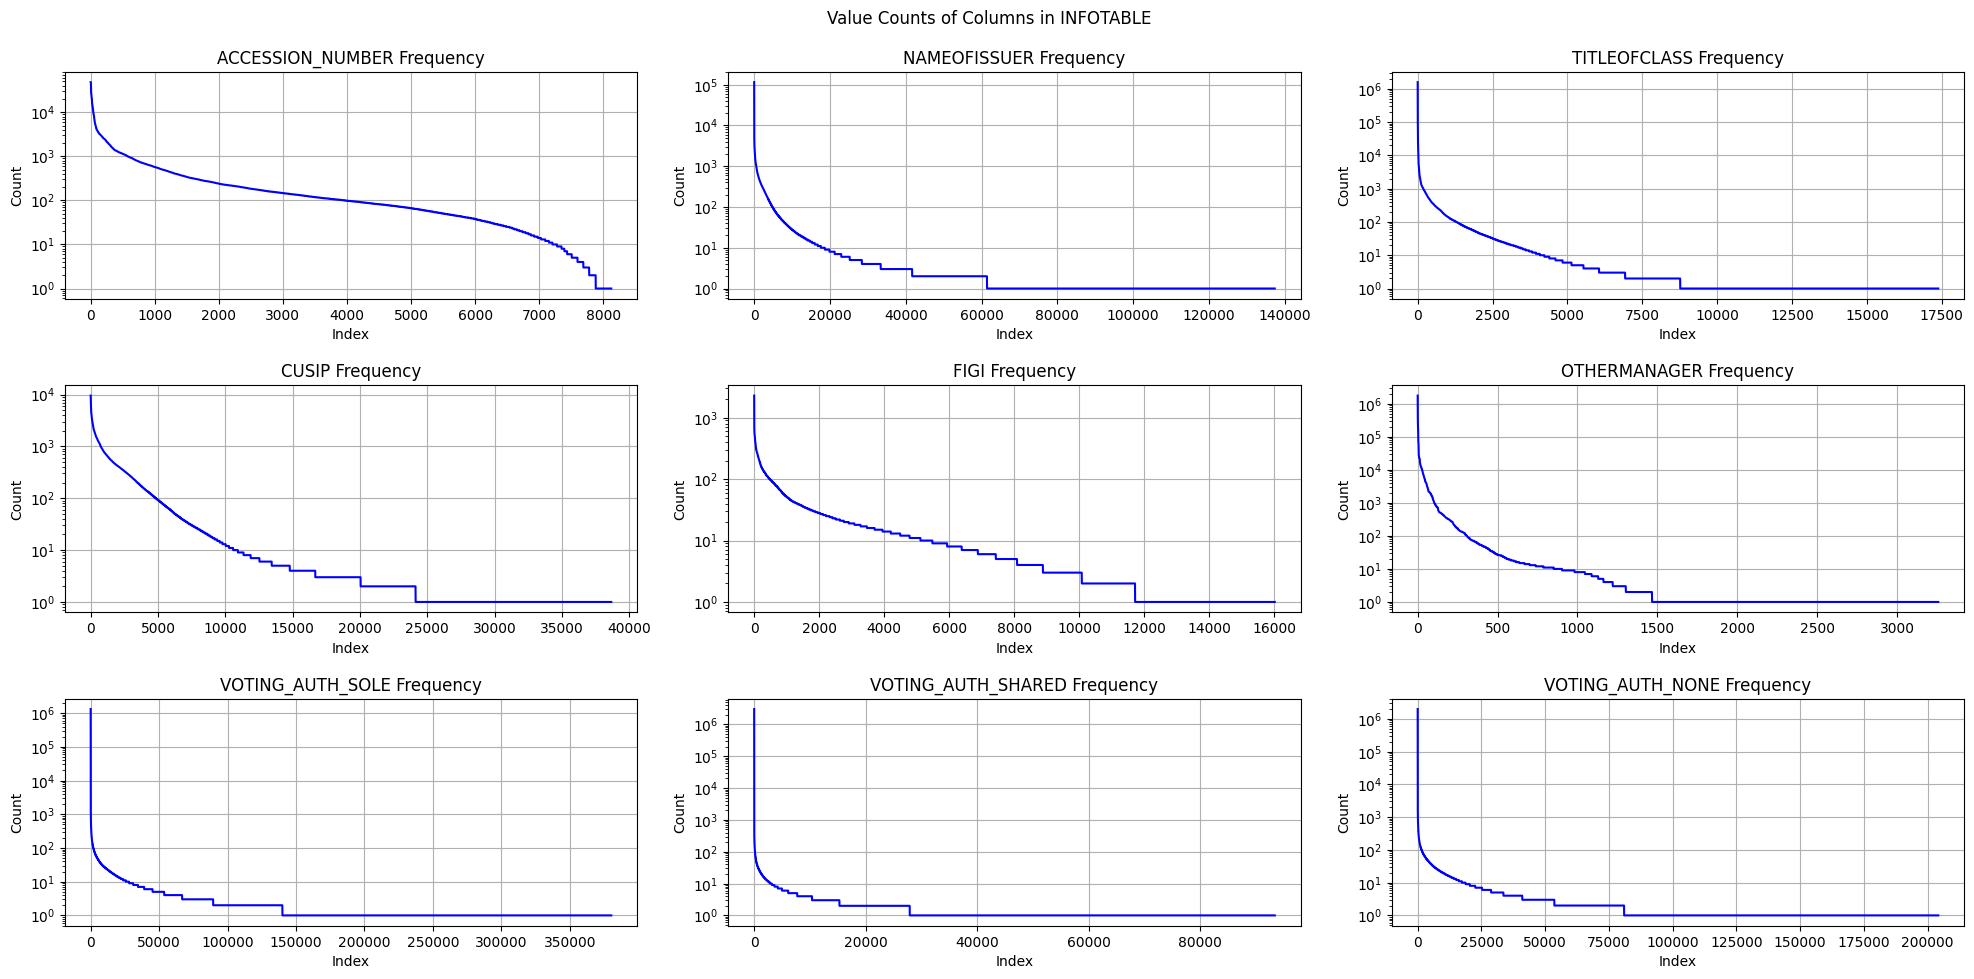

In [61]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))

ax[0,0].plot(df_infotable['ACCESSION_NUMBER'].value_counts().values, color='blue')
ax[0,0].set_yscale('log')
ax[0,0].set_title("ACCESSION_NUMBER Frequency")
ax[0,0].set_xlabel("Index")
ax[0,0].set_ylabel("Count")
ax[0,0].grid(True)

ax[0,1].plot(df_infotable['NAMEOFISSUER'].value_counts().values, color='blue')
ax[0,1].set_yscale('log')
ax[0,1].set_title("NAMEOFISSUER Frequency")
ax[0,1].set_xlabel("Index")
ax[0,1].set_ylabel("Count")
ax[0,1].grid(True)

ax[0,2].plot(df_infotable['TITLEOFCLASS'].value_counts().values, color='blue')
ax[0,2].set_yscale('log')
ax[0,2].set_title("TITLEOFCLASS Frequency")
ax[0,2].set_xlabel("Index")
ax[0,2].grid(True)
ax[0,2].set_ylabel("Count")

ax[1,0].plot(df_infotable['CUSIP'].value_counts().values, color='blue')
ax[1,0].set_yscale('log')
ax[1,0].set_title("CUSIP Frequency")
ax[1,0].set_xlabel("Index")
ax[1,0].set_ylabel("Count")
ax[1,0].grid(True)

ax[1,1].plot(df_infotable['FIGI'].value_counts().values, color='blue')
ax[1,1].set_yscale('log')
ax[1,1].set_title("FIGI Frequency")
ax[1,1].set_xlabel("Index")
ax[1,1].set_ylabel("Count")
ax[1,1].grid(True)

ax[1,2].plot(df_infotable['OTHERMANAGER'].value_counts().values, color='blue')
ax[1,2].set_yscale('log')
ax[1,2].set_title("OTHERMANAGER Frequency")
ax[1,2].set_xlabel("Index")
ax[1,2].set_ylabel("Count")
ax[1,2].grid(True)

ax[2,0].plot(df_infotable['VOTING_AUTH_SOLE'].value_counts().values, color='blue')
ax[2,0].set_yscale('log')
ax[2,0].set_title("VOTING_AUTH_SOLE Frequency")
ax[2,0].set_xlabel("Index")
ax[2,0].set_ylabel("Count")
ax[2,0].grid(True)

ax[2,1].plot(df_infotable['VOTING_AUTH_SHARED'].value_counts().values, color='blue')
ax[2,1].set_yscale('log')
ax[2,1].set_title("VOTING_AUTH_SHARED Frequency")
ax[2,1].set_xlabel("Index")
ax[2,1].set_ylabel("Count")
ax[2,1].grid(True)

ax[2,2].plot(df_infotable['VOTING_AUTH_NONE'].value_counts().values, color='blue')
ax[2,2].set_yscale('log')
ax[2,2].set_title("VOTING_AUTH_NONE Frequency")
ax[2,2].set_xlabel("Index")
ax[2,2].set_ylabel("Count")
ax[2,2].grid(True)

plt.suptitle("Value Counts of Columns in INFOTABLE")
plt.tight_layout(pad=1.5)
plt.show()

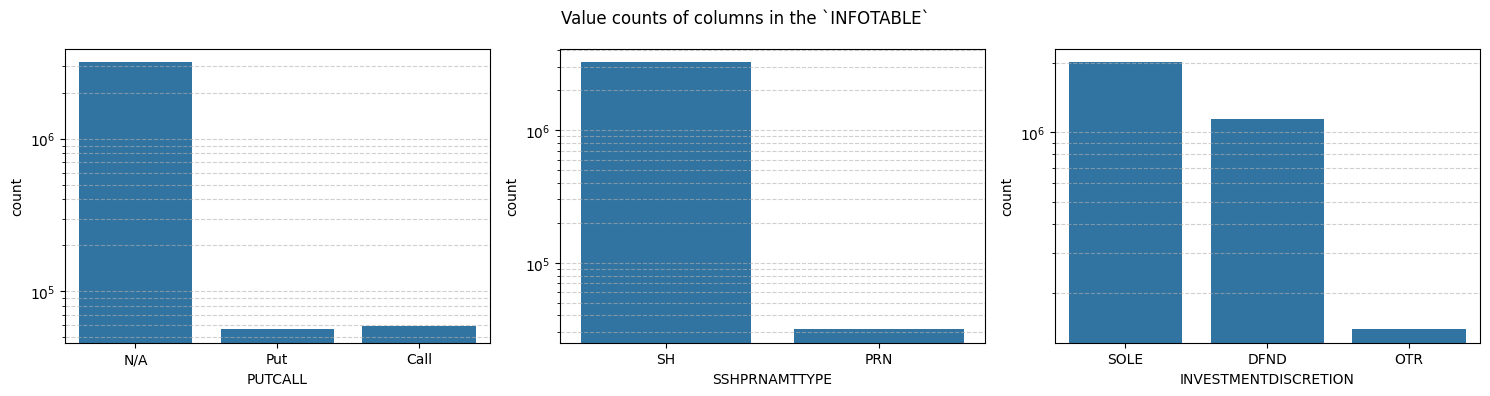

In [62]:
# plot the value counts
fig, ax = plt.subplots(1, 3,figsize=(15, 4))
sns.countplot(data=df_infotable, x='PUTCALL', ax=ax[0])
# ax[0].set_title('')
ax[0].set_yscale('log')
ax[0].grid(axis='y', linestyle='--', alpha=0.6, which='both')

sns.countplot(data=df_infotable, x='SSHPRNAMTTYPE', ax=ax[1])
ax[1].set_yscale('log')
ax[1].grid(axis='y', linestyle='--', alpha=0.6, which='both')

sns.countplot(data=df_infotable, x='INVESTMENTDISCRETION', ax=ax[2])
ax[2].set_yscale('log')
ax[2].grid(axis='y', linestyle='--', alpha=0.6, which='both')

plt.suptitle('Value counts of columns in the `INFOTABLE`')
plt.tight_layout()
plt.show()